In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F


# Define Data

In [3]:
df = pd.read_csv('../project_2/catdogdata.txt', delimiter = ' ')



df['label'] = 0 # cats are the first 99 entries
df.loc[99:198, 'label'] = 1 # dogs are the next 99 entries


df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V4088,V4089,V4090,V4091,V4092,V4093,V4094,V4095,V4096,label
1,23,23,20,20,9,9,9,4,4,4,...,108,108,108,89,65,51,31,23,9,0
2,250,250,250,244,244,244,244,244,232,232,...,244,244,232,244,244,244,244,232,244,0
3,137,137,137,144,151,151,151,158,151,151,...,89,89,78,78,78,100,102,124,124,0
4,55,55,55,55,55,55,55,55,55,55,...,45,45,45,45,45,45,37,45,52,0
5,173,173,173,173,158,158,158,158,153,149,...,64,64,48,48,77,98,64,45,45,0


In [4]:
def plot_examples(df, n=10):
    """
    Plot n examples from the dataset.
    Assumes the last column is the label.
    """
    indices = np.random.choice(df.index, n, replace=False)
    df = df.loc[indices]
    
    fig, axes = plt.subplots(1, n, figsize=(2.5 * n, 3))
    for i in range(n):
        image = df.iloc[i, :-1].values.reshape((64, 64))
        label = df.iloc[i, -1]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

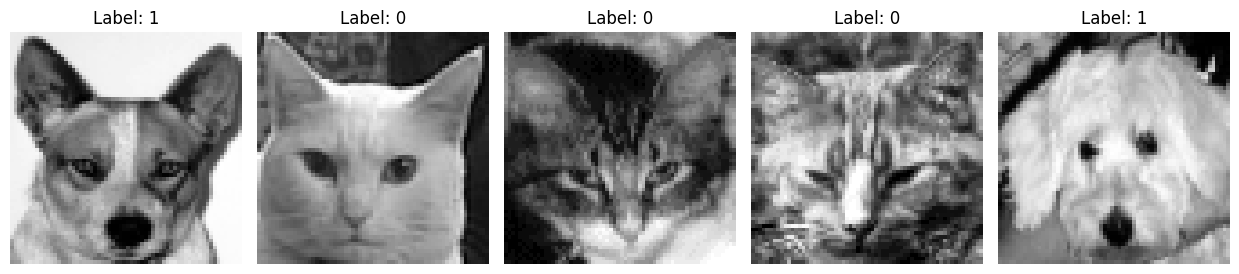

In [5]:
# Rotate all images 90 degrees clockwise
def rotate_image(image):
    return np.rot90(image.reshape(64, 64), -1).flatten()

# Apply the rotation to all rows and update the DataFrame
rotated_images = np.array([rotate_image(row.values) for _, row in df.iloc[:, :-1].iterrows()])
df.iloc[:, :-1] = rotated_images

# plot example images after rotation
plot_examples(df, n=5)

In [8]:
df_mnist = pd.read_csv('../project_2/Numbers.txt', delimiter=' ')

# first column is the label
df_mnist['label'] = df_mnist.iloc[:, 0]
df_mnist = df_mnist.iloc[:, 1:]
X_mnist = df_mnist.iloc[:, :-1].values
y_mnist = df_mnist.iloc[:, -1].values


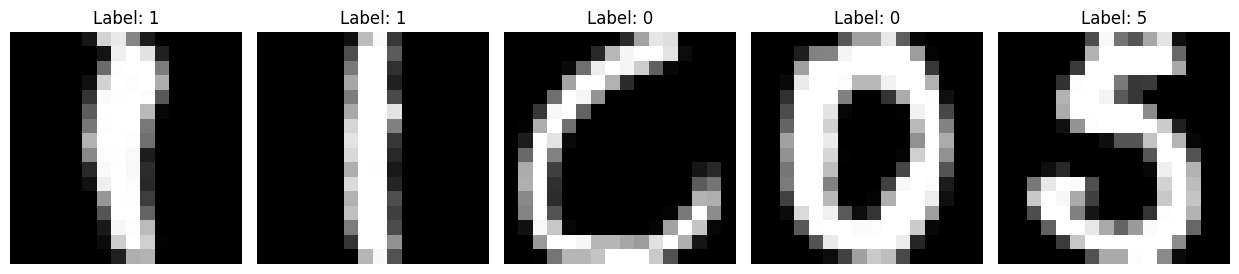

In [9]:
# create a function to plot examples
def plot_examples_mnist(df, n=10):
    """
    Plot n examples from the dataset.
    Assumes the last column is the label.
    """
    indices = np.random.choice(df.index, n, replace=False)
    df = df.loc[indices]
    
    fig, axes = plt.subplots(1, n, figsize=(2.5 * n, 3))
    for i in range(n):
        image = df.iloc[i, :-1].values.reshape((16, 16))
        label = df.iloc[i, -1]
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
# plot example images
plot_examples_mnist(df_mnist, n=5)

# Make a low dimensional representation

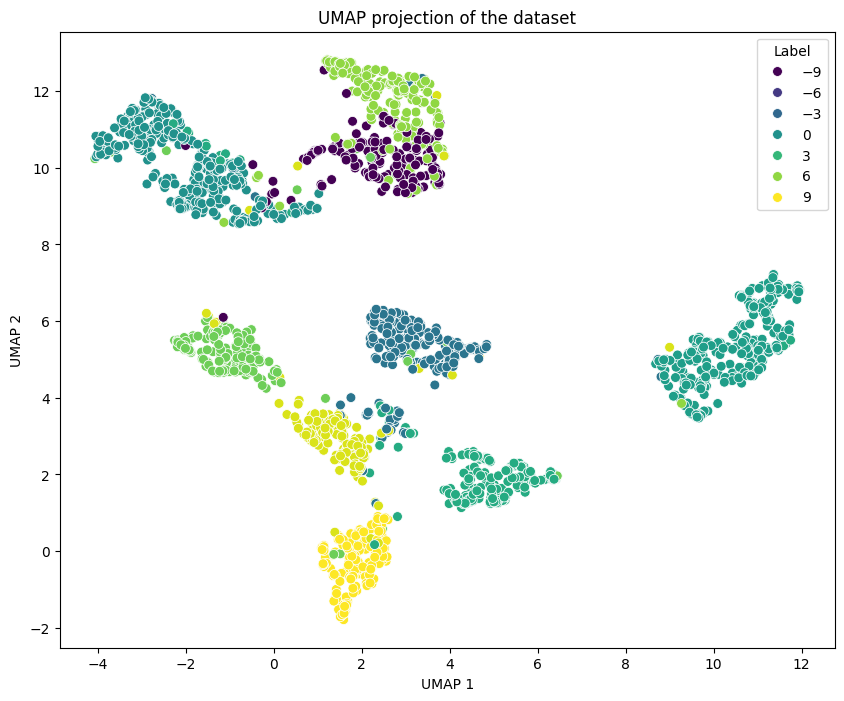

In [60]:
# Use UMAP to create a low-dimensional representation of the data
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming df is your DataFrame and the last column is the label
X = df_mnist.iloc[:, :-1].values
y = df_mnist.iloc[:, -1].values
# Create a UMAP model
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2)

# Fit and transform the data
X_umap = umap_model.fit_transform(X)

# Plot the UMAP representation
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis', s=50)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Label')
plt.show()

In [99]:
from sklearn.metrics import davies_bouldin_score

def dbscan_CVinnerloop(eps_grid, min_samples_grid, X_umap, y, mode='silhouette'):
    """
    Perform DBSCAN clustering with cross-validation to find the best parameters.
    Returns the best parameters, best score, and the cluster labels using the best model on the full dataset.
    """
    import numpy as np
    from sklearn.cluster import DBSCAN
    from sklearn.metrics import silhouette_score
    from sklearn.model_selection import KFold

    best_score = -np.inf
    best_params = None
    best_labels = None

    # Create a KFold object for cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for eps in eps_grid:
        for min_samples in min_samples_grid:
            scores = []
            for train_index, test_index in kf.split(X_umap):
                X_train = X_umap[train_index]

                # Apply DBSCAN
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                dbscan.fit(X_train)

                if mode == 'silhouette':
                    if len(set(dbscan.labels_)) > 1:
                        score = silhouette_score(X_train, dbscan.labels_)
                        scores.append(score)

                elif mode == 'dbi':
                    labels = dbscan.labels_
                    if len(set(labels)) > 1 and len(set(labels)) != 1 + (-1 in labels):
                        score = -davies_bouldin_score(X_train, labels)
                        scores.append(score)

                else:
                    raise ValueError("Invalid mode. Choose 'silhouette' or 'dbi'.")

            if scores:
                mean_score = np.mean(scores)
                if mean_score > best_score:
                    best_score = mean_score
                    best_params = (eps, min_samples)

    # Fit the best model on the full dataset
    if best_params:
        best_dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
        best_dbscan.fit(X_umap)
        best_labels = best_dbscan.labels_

    return best_params, best_score, best_labels


def dbscan_outerloop(num_runs, eps_grid, min_samples_grid, X_umap, y, mode='silhouette'):
    """
    Perform DBSCAN CV outer loop to find stability of running inner loop multiple times.
    Returns best parameters, scores, labels, and stability metrics (ARI/NMI matrices).
    Also plots the resulting clusters for each run.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    best_params_list = []
    best_scores_list = []
    best_labels_list = []

    for run in range(num_runs):
        best_params, best_score, best_labels = dbscan_CVinnerloop(
            eps_grid, min_samples_grid, X_umap, y, mode = mode
        )
        best_params_list.append(best_params)
        best_scores_list.append(best_score)
        best_labels_list.append(best_labels)

    # Compute ARI and NMI matrices
    ari_matrix = np.zeros((num_runs, num_runs))
    nmi_matrix = np.zeros((num_runs, num_runs))

    for i in range(num_runs):
        for j in range(num_runs):
            if i != j:
                ari_matrix[i, j] = adjusted_rand_score(best_labels_list[i], best_labels_list[j])
                nmi_matrix[i, j] = normalized_mutual_info_score(best_labels_list[i], best_labels_list[j])
            else:
                ari_matrix[i, j] = 1.0
                nmi_matrix[i, j] = 1.0

    # Plot clusters from each run
    fig, axes = plt.subplots(1, num_runs, figsize=(5 * num_runs, 4), squeeze=False)
    for i, labels in enumerate(best_labels_list):
        ax = axes[0][i]
        scatter = ax.scatter(
            X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', s=10
        )
        ax.set_title(f'Run {i+1}\nParams: eps = {best_params_list[i][1]} min_samples = {best_params_list[i][0]}')
        ax.set_xlabel('UMAP-1')
        ax.set_ylabel('UMAP-2')
    plt.tight_layout()
    plt.show()

    return {
        "best_params_list": best_params_list,
        "best_scores_list": best_scores_list,
        "best_labels_list": best_labels_list,
        "ari_matrix": ari_matrix,
        "nmi_matrix": nmi_matrix,
    }


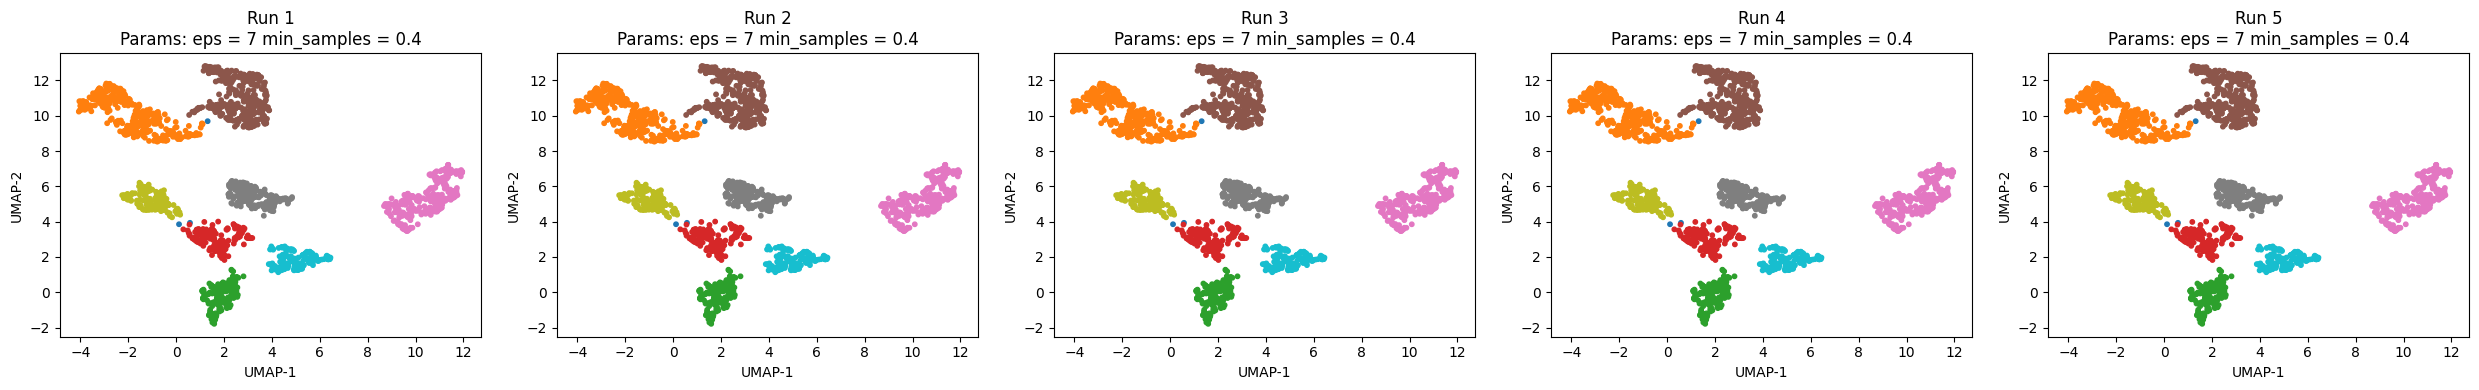

ARI: 1.0
NMI: 1.0


In [100]:
eps_grid = np.arange(0.1, 1.0, 0.1)
min_samples_grid = np.arange(1, 10, 1)
num_runs = 5

results = dbscan_outerloop(num_runs, eps_grid, min_samples_grid, X_umap, y, mode ='silhouette')
# Extract the ARI and NMI matrices
ari_matrix = results['ari_matrix']
nmi_matrix = results['nmi_matrix']
# Print the ARI and NMI scores
ari_matrix_no_diag = ari_matrix[~np.eye(ari_matrix.shape[0], dtype=bool)].reshape(ari_matrix.shape[0], -1)
nmi_matrix_no_diag = nmi_matrix[~np.eye(nmi_matrix.shape[0], dtype=bool)].reshape(nmi_matrix.shape[0], -1)
print("ARI:" , ari_matrix_no_diag.mean())
print("NMI:" , nmi_matrix_no_diag.mean())


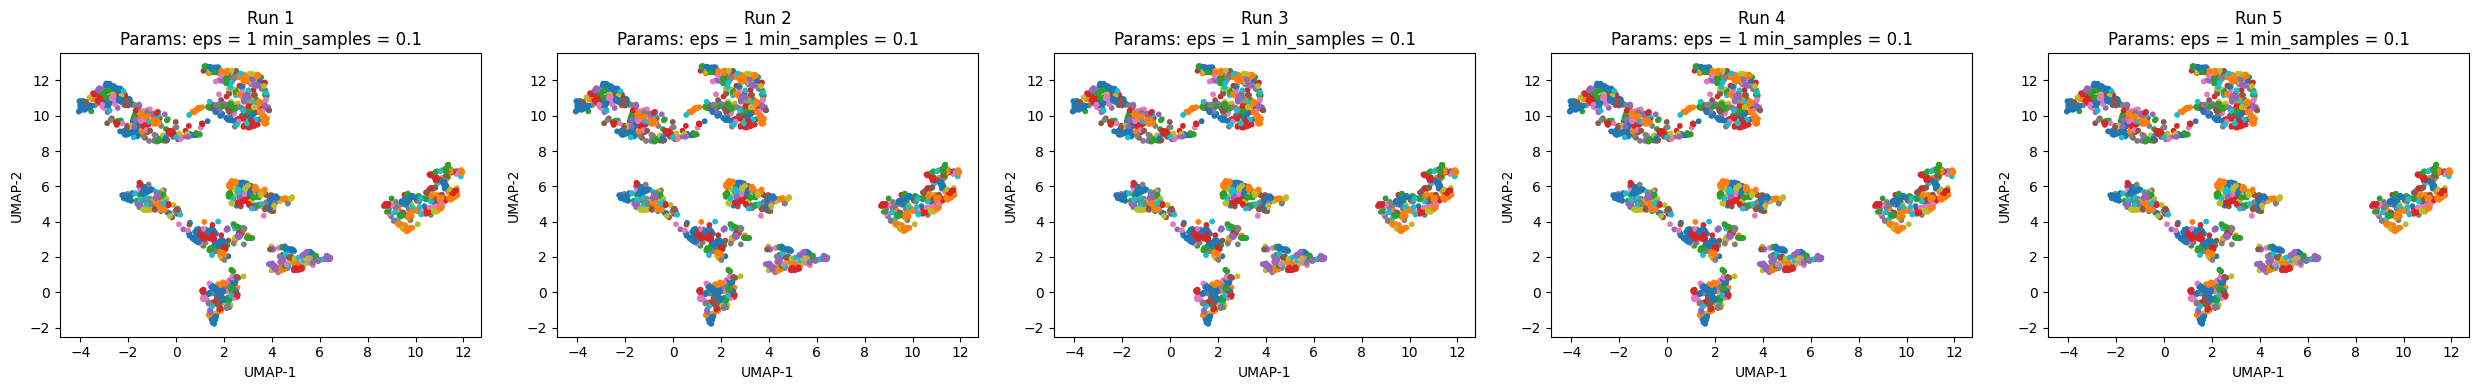

ARI: 1.0
NMI: 1.0


In [101]:
eps_grid = np.arange(0.1, 1.0, 0.1)
min_samples_grid = np.arange(1, 10, 1)
num_runs = 5

results = dbscan_outerloop(num_runs, eps_grid, min_samples_grid, X_umap, y, mode ='dbi')
# Extract the ARI and NMI matrices
ari_matrix = results['ari_matrix']
nmi_matrix = results['nmi_matrix']

# Print the ARI and NMI scores (removing the diagonal)
ari_matrix_no_diag = ari_matrix[~np.eye(ari_matrix.shape[0], dtype=bool)].reshape(ari_matrix.shape[0], -1)
nmi_matrix_no_diag = nmi_matrix[~np.eye(nmi_matrix.shape[0], dtype=bool)].reshape(nmi_matrix.shape[0], -1)
print("ARI:" , ari_matrix_no_diag.mean())
print("NMI:" , nmi_matrix_no_diag.mean())


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


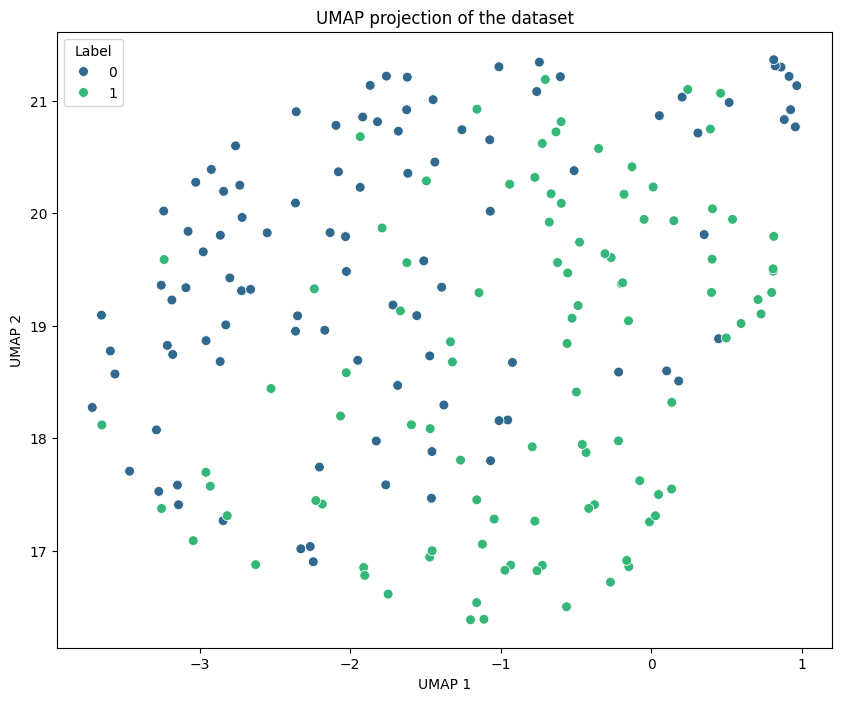

In [102]:
# Now for the cat-dog dataset
# Use UMAP to create a low-dimensional representation of the data

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Create a UMAP model
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the data
X_umap = umap_model.fit_transform(X)
# Plot the UMAP representation
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='viridis', s=50)
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Label')
plt.show()


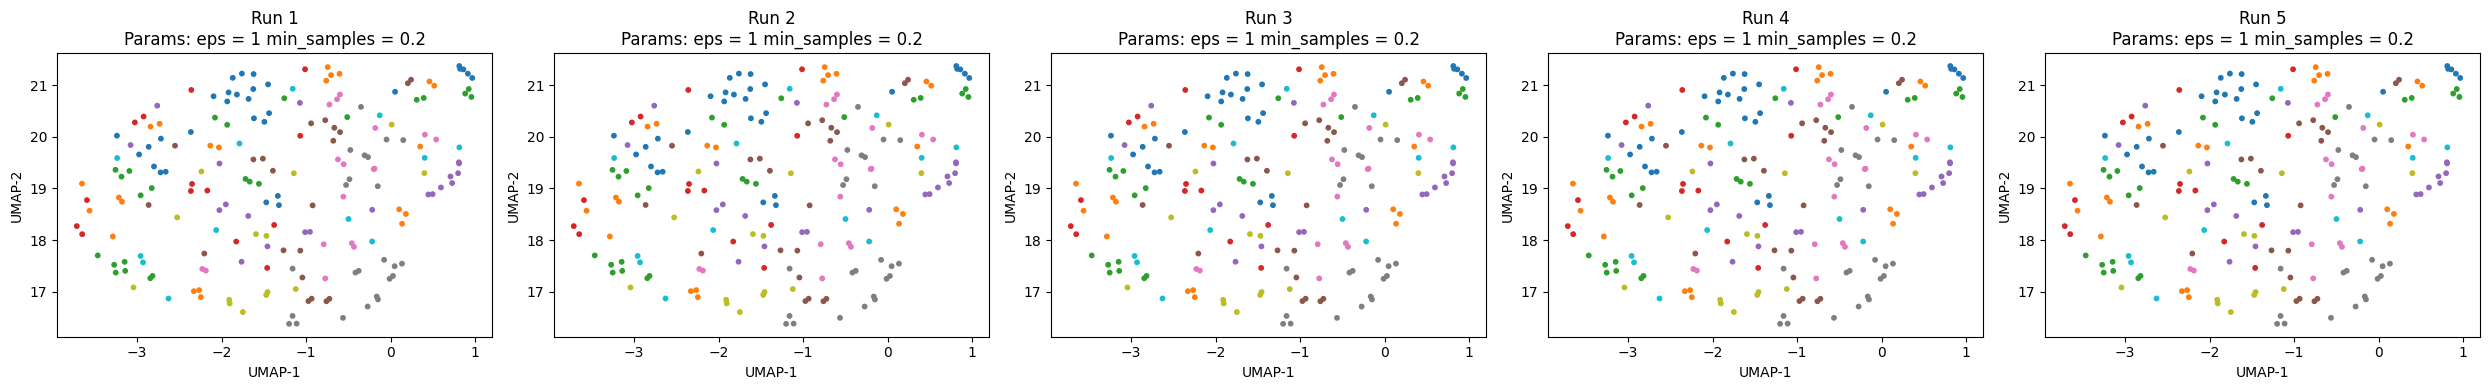

ARI: 1.0
NMI: 1.0


In [103]:
eps_grid = np.arange(0.1, 1.0, 0.1)
min_samples_grid = np.arange(1, 10, 1)
num_runs = 5

results = dbscan_outerloop(num_runs, eps_grid, min_samples_grid, X_umap, y, mode ='silhouette')
# Extract the ARI and NMI matrices
ari_matrix = results['ari_matrix']
nmi_matrix = results['nmi_matrix']
# Print the ARI and NMI scores
ari_matrix_no_diag = ari_matrix[~np.eye(ari_matrix.shape[0], dtype=bool)].reshape(ari_matrix.shape[0], -1)
nmi_matrix_no_diag = nmi_matrix[~np.eye(nmi_matrix.shape[0], dtype=bool)].reshape(nmi_matrix.shape[0], -1)
print("ARI:" , ari_matrix_no_diag.mean())
print("NMI:" , nmi_matrix_no_diag.mean())


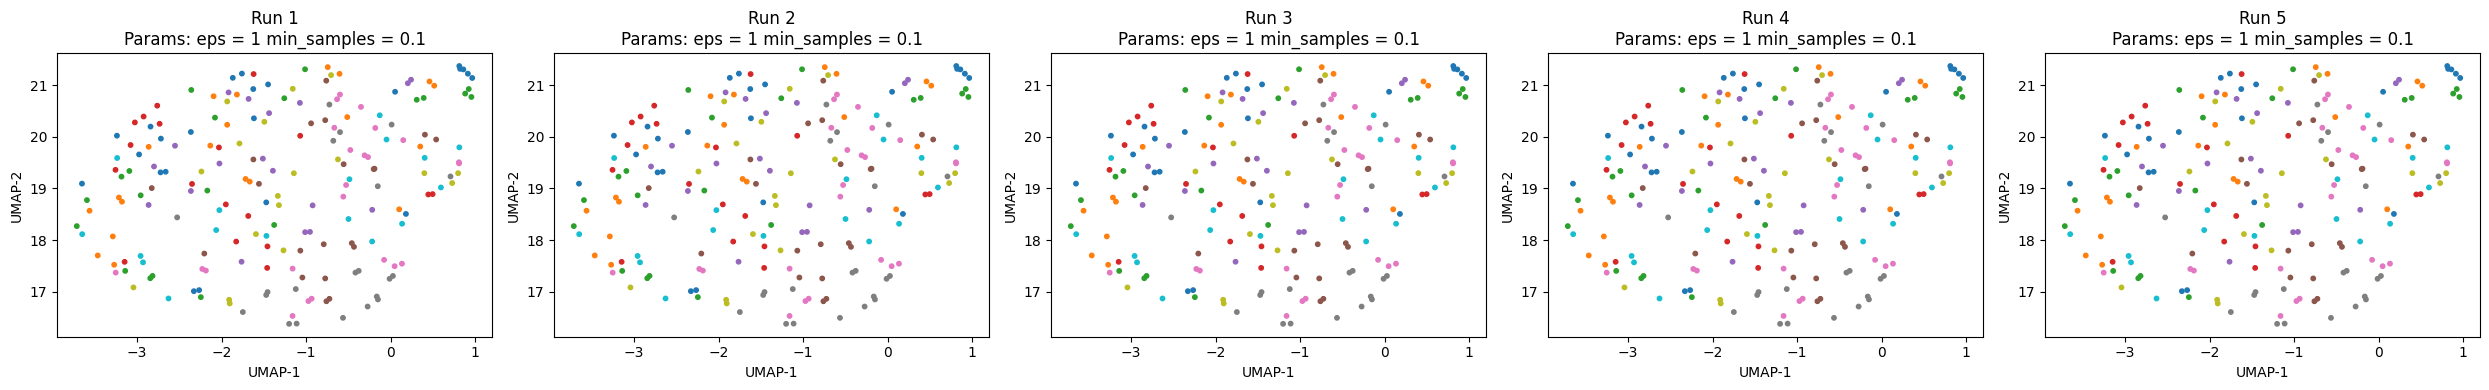

ARI: 1.0
NMI: 1.0


In [104]:
eps_grid = np.arange(0.1, 1.0, 0.1)
min_samples_grid = np.arange(1, 10, 1)
num_runs = 5

results = dbscan_outerloop(num_runs, eps_grid, min_samples_grid, X_umap, y, mode ='dbi')
# Extract the ARI and NMI matrices
ari_matrix = results['ari_matrix']
nmi_matrix = results['nmi_matrix']

# Print the ARI and NMI scores (removing the diagonal)
ari_matrix_no_diag = ari_matrix[~np.eye(ari_matrix.shape[0], dtype=bool)].reshape(ari_matrix.shape[0], -1)
nmi_matrix_no_diag = nmi_matrix[~np.eye(nmi_matrix.shape[0], dtype=bool)].reshape(nmi_matrix.shape[0], -1)
print("ARI:" , ari_matrix_no_diag.mean())
print("NMI:" , nmi_matrix_no_diag.mean())


# Part 2 - Theme Imbalance and Sample size